In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from utils_HD import MatConvert, MMDu, TST_MMD_u
from mmd_d import train_model, test_distribution

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn import tree

import pydotplus
from subprocess import check_call

from graphviz_sql.extract import to_sql 
import sqlite3
import pickle
from scipy import stats
import sys
import argparse
import pickle
from scipy import stats
import sys
import argparse
import os

import time

import joblib


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def low_acc_sample(model, x_data, y_data):
    y_predict_data = model.predict(x_data)
    y_data = y_data.reset_index()
    y_predict_data = pd.DataFrame(y_predict_data, columns = ['predict'])
   

    data_result = pd.concat([y_data, y_predict_data], axis=1, join='inner')
    data_result['result'] = np.where(data_result['label']==data_result['predict'],'0','1')
    print(data_result['result'].value_counts())
    data_result.set_index(["index"], inplace=True)
    data_result = pd.concat([data_result, x_data], axis=1, join='inner')
    # data_result_0 = data_result[data_result['result'] == "0"]
    # data_result_0 = data_result_0.sample(frac=0.05, random_state=42)
    if len(data_result[data_result['result'] == "1"])>250:
        data_result_1 = data_result[data_result['result'] == "1"].head(250)
    else:
        data_result_1 = data_result[data_result['result'] == "1"]
    n= 500-len(data_result_1)    
    data_result_0 = data_result[data_result['result'] == "0"]
    data_result_0 = data_result_0.head(n)
    data_result = pd.concat([data_result_0, data_result_1], axis=0)
    data_result = data_result.sample(frac=1, random_state=42)
    x_data = data_result.drop(columns=["label","predict","result"])
    y_data = data_result['label']

    y_predict_data = model.predict(x_data)

    data_result=data_result.drop(columns=["predict","result"])
    return data_result

In [4]:
def assign_to_teams(model, X_test):
    leaf_indices = model.apply(X_test)
    return leaf_indices

def find_distributions(model, data,acc_tre):

    X_test = data.drop(columns=["label"])
    y_test = data[["label"]]
    y_predict = model.predict(X_test)
    #y_predict = np.argmax(y_predict, axis=1)
    #y_predict = (y_predict > 0.5).astype(int)
    y_test_DT = y_test.reset_index()
    y_predict_DT = pd.DataFrame(y_predict, columns = ['predict'])
    data_M2 = pd.concat([y_test_DT, y_predict_DT], axis=1, join='inner')
    # Calculate the prediction error
    # print(y_test)
    # print(y_predict.shape)
    error = np.abs(y_test.values.flatten() - y_predict)
    # Create a DataFrame for the prediction error
    error_df = pd.DataFrame(error, columns=['error'])

    # Calculate the threshold for the top 30% prediction error
    threshold = error_df['error'].quantile(acc_tre)

    # Generate the 'result' values based on the prediction error
    data_M2['result'] = np.where(error_df['error'] < threshold, '0', '1')
    
    #data_M2['result'] = np.where(data_M2["label"]==data_M2['predict'],'0','1')
    data_M2.set_index(["index"], inplace=True)
    data_M2 = pd.concat([data_M2, X_test], axis=1, join='inner')

    x_DT = data_M2.drop(columns=["label", "predict", "result" ])
    y_DT = data_M2[["result"]]

    #train Decision tree
    model_DT = DecisionTreeClassifier(
                                        max_depth=17,
                                      min_samples_leaf=30,
                                      random_state=42
                               )

    model_DT.fit(x_DT, y_DT)


    ##save DT tree plan dot
    
    teams = assign_to_teams(model_DT, X_test)

 

    data_M2['team'] = teams
    #print(data_M2.team.value_counts())
    
        # Group by 'team' and calculate the value counts for 'result'
    df1 = data_M2['team'].value_counts().to_frame()

    # Calculate the accuracy for each team
    g = data_M2.groupby("team")
    m = g['result'].value_counts(normalize=True,sort=False)
    acc = m.loc[:,'0'].to_frame()

    # Combine the count and accuracy data
    List_accuracy = pd.concat([acc, df1], axis=1, join='inner')
    accuracy_team = List_accuracy.reset_index()

    accuracy_team['percentage'] = accuracy_team['team'] / len(X_test)

    accuracy_team = accuracy_team.rename(columns={'team':'count'})
    accuracy_team = accuracy_team.rename(columns={'result':'Accuracy'})
    accuracy_team = accuracy_team.rename(columns={'index':'Team_number'})
    #print(f"accuracy_team:\n{accuracy_team}")
    return accuracy_team, model_DT
    


In [5]:
def find_data(model, data, data_serv, acc_tre):
    # 创建一个空的DataFrame用于存储所有的sub_data
    merged_data = pd.DataFrame()
    data_serv.reset_index(inplace=True)
    # 将sub_data的索引作为一列

    for i in range(50):
        data1=data.sample(int(len(data)*0.95), replace=True)
        X_test = data1.drop(columns=["label"])
        y_test = data1[["label"]]
        y_predict = model.predict(X_test)
        #y_predict = np.argmax(y_predict, axis=1)
        #y_predict = (y_predict > 0.5).astype(int)
        y_test_DT = y_test.reset_index()
        y_predict_DT = pd.DataFrame(y_predict, columns = ['predict'])
        data_M2 = pd.concat([y_test_DT, y_predict_DT], axis=1, join='inner')
        error = np.abs(y_test.values.flatten() - y_predict)
        # Create a DataFrame for the prediction error
        error_df = pd.DataFrame(error, columns=['error'])

        # Calculate the threshold for the top 30% prediction error
        threshold = error_df['error'].quantile(acc_tre)

        # Generate the 'result' values based on the prediction error
        data_M2['result'] = np.where(error_df['error'] < threshold, '0', '1')
        #data_M2.set_index(["index"], inplace=True)
        data_M2.reset_index(inplace=True)
        X_test.reset_index(inplace=True)


        data_M2 = pd.concat([data_M2, X_test], axis=1, join='inner')
    


        x_DT = data_M2.drop(columns=["label", "predict", "result", "level_0",  "index" ])
        y_DT = data_M2[["result"]]


        #train Decision tree
        model_DT = DecisionTreeClassifier(
                    max_depth=17,
            min_samples_leaf=10,
                    random_state=42
            )

        model_DT.fit(x_DT, y_DT)

        

        X_test_serv = data_serv.drop(columns=["label", "index"])
        y_test_serv = data_serv[["label"]]
        
        
        #print(data_serv.shape)
  

        # 获取决策树的预测结果
        tree_predictions = model_DT.predict(X_test_serv)
        
        tree_predictions = pd.DataFrame(tree_predictions, columns = ['predict'])
        # print(f'{i} tree_predictions: {tree_predictions}')
        # tree_predictions.reset_index(inplace=True)

        data_sample = pd.concat([data_serv, tree_predictions], axis=1, join='inner')
        
        data_sample = data_sample[data_sample['predict'] == "1"]
        #print(f' selected_data:{selected_data}')
        #data_sample = selected_data
        data_sample=data_sample.drop(columns=["predict"])
        # print(f'{i} low accuracy data:{data_sample}')

        merged_data = pd.concat([merged_data, data_sample])
    # 统计每个样本的重复次数
    # print(f' merged_data: {merged_data.info()}')
    duplicate_counts = merged_data['index'].value_counts()
    # print(duplicate_counts)
    # duplicate_rows = merged_data.duplicated(subset='index')
    # duplicate_counts = duplicate_rows.value_counts()
    # print(duplicate_counts)

    # 筛选重复次数大于1的数据
    filtered_duplicate_counts = duplicate_counts[duplicate_counts > 1]

    # 绘制重复次数大于1的直方图
    plt.bar(filtered_duplicate_counts.index, filtered_duplicate_counts.values)
    plt.xlabel('Sample ID')
    plt.ylabel('Duplicate Count')
    plt.title('Distribution of Duplicate Counts (Count > 1)')
    plt.show()

    
    duplicate_counts = merged_data['index'].value_counts().sort_values(ascending=False)
    total_count = len(duplicate_counts)
    extract_count = int(total_count * 0.9)
    top_values = duplicate_counts.index[:extract_count]
    deduplicated_data = merged_data[merged_data['index'].isin(top_values)]
    deduplicated_data = deduplicated_data.drop_duplicates()
    deduplicated_data=deduplicated_data.drop(columns=["index"])

    #print(f' deduplicated_data: {deduplicated_data.info()}')
    

    return deduplicated_data
    


In [6]:
# 定义检测函数
from scipy.stats import ks_2samp
def drift_detection(X_train, X_test, threshold=0.05):
    """
    检测数据分布是否漂移
    """
    # 提取特征列表
    features = X_train.columns.tolist()

    # 初始化检测结果列表
    results = []

    # 针对每个特征，计算p-value和KS统计量
    for feature in features:
        # 获取训练数据和测试数据中的该特征的值
        train_values = X_train[feature].values
        test_values = X_test[feature].values

        # 计算KS统计量和p-value
        ks_statistic, p_value = ks_2samp(train_values, test_values)

        # 判断是否漂移
        if p_value < threshold:
            drift = True
        else:
            drift = False

        # 记录检测结果
        results.append({
            "feature": feature,
            "p_value": p_value,
            "ks_statistic": ks_statistic,
            "drift": drift
        })
    is_drift = any([result["drift"] for result in results])   

    # 返回结果列表
    return is_drift

In [7]:
import numpy as np
from sklearn import metrics

def mmd_fast(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
        # 根据MMD值判断是否存在数据漂移
    print(f'mmd : {mmd}')
    is_drift_mmd=False
    if mmd > 0.00001:
        is_drift_mmd=True
    return is_drift_mmd

In [8]:
####  H-D
join=os.path.join
from sklearn.decomposition import PCA
# parser = argparse.ArgumentParser()

# parser.add_argument('--n', type=int, default=300)
# parser.add_argument('--seed', type=int, default=1)
# parser.add_argument('--log_dir', type=str, default='logs')
# parser.add_argument('--runs', type=int, default=1)

n=200
seed=1
log_dir='logs'
runs=1
#bandwidth = 'scott'
max_data_size = n
# args = parser.parse_args()

np.random.seed(seed)

from sklearn.neighbors import KernelDensity
import numpy as np

def scotts_bandwidth(data):
    """根据 Scott's Rule 计算带宽."""
    n_samples, d = data.shape  # 样本量和数据的维度
    return np.power(n_samples, -1./(d+4)) * np.std(data, axis=0).mean()  # 使用平均标准差

def get_kde_estimates(data):
    data = data.T  # 转置数据以符合 sklearn 的格式要求
    bandwidth = scotts_bandwidth(data)
    
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(data)
    log_dens = kde.score_samples(data)
    return np.exp(log_dens)  # 返回概率密度值


if not os.path.exists(log_dir):
	os.makedirs(log_dir)




fname = join(log_dir, 'result_' + str(max_data_size) + '.txt')

def in_top_k(scores, k):
    indices = np.argsort(scores)[::-1]
    pos = np.where(indices==0)[0][0]
    print(f"pos:{pos}")
    return pos <= k

def evaluate(data_1,data_2):
    scores = []
    data1 = data_1.sample(n=200,  random_state=42).to_numpy()
    data2 = data_2.to_numpy()
  
    for rep in range(100):

        if rep != 0:
            data_all = np.concatenate([data1, data2], axis=0)
            data_all = data_all[np.random.permutation(range(data_all.shape[0]))]
            data1 = data_all[:max_data_size]
            data2 = data_all[max_data_size:]
        datam = np.concatenate([data1[:max_data_size//2], data2[:max_data_size//2]], axis=0)

        logprob_1 = get_kde_estimates( data1)
        logprob_2 = get_kde_estimates(data2)
        logprob_m = get_kde_estimates(datam)
        #print(logprob_1)

        vdiv = np.mean(-logprob_m) - min(np.mean(-logprob_1), np.mean(-logprob_2))
        with open(fname, 'a') as f:
            f.write("Scores " + str(np.mean(logprob_1)) + " " + str(np.mean(logprob_2)) + " " + str(np.mean(logprob_m)) + "\n")
        scores.append(vdiv)

    return in_top_k(scores, k=100)





In [9]:

train_data_df = pd.read_csv("./M-Minist/train_s100_input.txt", header=None)
# Convert the values to floats
train_data_df = train_data_df[0].str.split(' ', expand=True)

In [10]:
train_label_df = pd.read_csv("./M-Minist/train_s100_label.txt", header=None)
# Convert the values to floats
#train_label_df = train_label_df[0].str.split(' ', expand=True)
train_label_df=train_label_df.rename(columns={0:'label'})

train_data = pd.concat([train_label_df, train_data_df], axis=1)
train_data = train_data.fillna(0)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 785 entries, label to 783
dtypes: float64(1), object(784)
memory usage: 15.0+ MB


In [11]:
test1_data_df = pd.read_csv("./M-Minist/train_s90_input.txt", header=None)
# Convert the values to floats
test1_data_df = test1_data_df[0].str.split(' ', expand=True)

test1_label_df = pd.read_csv("./M-Minist/train_s90_label.txt", header=None)
# Convert the values to floats
#train_label_df = train_label_df[0].str.split(' ', expand=True)
test1_label_df=test1_label_df.rename(columns={0:'label'})

test1_data = pd.concat([test1_label_df, test1_data_df], axis=1)
test1_data = test1_data.fillna(0)
test1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 785 entries, label to 783
dtypes: float64(1), object(784)
memory usage: 15.0+ MB


In [12]:
train_data= pd.concat([train_data, test1_data], axis=0)
train_data = train_data.reset_index(drop=True)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 785 entries, label to 783
dtypes: float64(1), object(784)
memory usage: 29.9+ MB


In [13]:
test_data_df = pd.read_csv("./M-Minist/test_s50_input.txt", header=None)
# Convert the values to floats
test_data_df = test_data_df[0].str.split(' ', expand=True)

test_label_df = pd.read_csv("./M-Minist/test_s50_label.txt", header=None)
# Convert the values to floats
#train_label_df = train_label_df[0].str.split(' ', expand=True)
test_label_df=test_label_df.rename(columns={0:'label'})

test_data = pd.concat([test_label_df, test_data_df], axis=1)
test_data = test_data.fillna(0)
test_data.head()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,577.820552,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,...,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00
1,699.553499,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,...,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00
2,638.172616,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,...,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00
3,645.440685,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,...,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00
4,623.756488,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,...,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00


In [14]:
test_data.info()
# print(train_data.dtypes)
# print(test_data.dtypes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 785 entries, label to 783
dtypes: float64(1), object(784)
memory usage: 12.0+ MB


## Repeat 100 times test


len train set:5000
len test set:2000
Accuracy Score is 0.87597
pos:99
The 0 batch serving data real acc: 0.8885133974684349
[]
the 0 batch serving data's drift figure


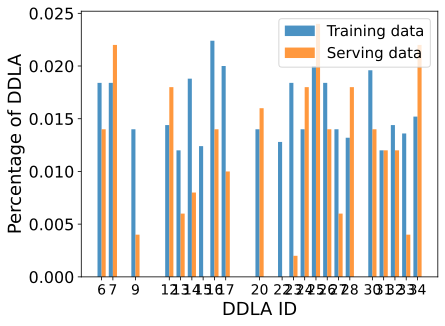

The 0 No retrain


In [18]:

from mmd_d import train_model, test_distribution, train_C2ST_model, test_C2ST_S, test_C2ST_L

import numpy as np
import torch
import pickle
import argparse
parser = argparse.ArgumentParser()
from utils_HD import MatConvert, MMDu, TST_MMD_u
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import argparse
from utils_HD import MatConvert, MMDu, TST_MMD_u
import time
import matplotlib.pyplot as plt

# 初始化时间计数器
time_ddla, time_ks, time_mmd, time_hd, time_mmdd, time_c2sts, time_c2stl = 0, 0, 0, 0, 0, 0, 0


batch_size = 500
n_batch = 100
#sorted_data = df_all_std.sort_values(by=['race', 'sex'])
is_drift_list=[]
PDDLA_Increase_list = []
is_drift_mmd_list = []
is_drift_hd_list=[]
is_drift_KS_list = []
is_drift_ddla_list = []
is_drift_mmdd_list = []
is_drift_c2sts_list = []
is_drift_c2stl_list = []

Number_AL=[]
Number_AL_KS=[]
Number_AL_MMD=[]
Number_AL_HD=[]
Number_AL_MMDD=[]

accuracy_sample_list = []
accuracy_sample_list_DDLA = []
accuracy_sample_list_MMD = []
accuracy_sample_list_MMDD = []
accuracy_sample_list_HD = []
accuracy_sample_list_KS = []
accuracy_sample_list_random =[]
accuracy_sample_list_real_random = []


accuracy_sample_high_count=0

PDDLA_Increase_count = 0
count_retrain_KS = 0
count_retrain_MMD = 0
count_retrain_HD = 0
count_retrain_MMDD = 0

trainingtime_list_DDLA = []
trainingtime_list_KS = []
trainingtime_list_MMD = []
trainingtime_list_HD = []


# ###training the model fot the MMD-D
model_C2STL, w_C2STL, b_C2STL = train_C2ST_model(train_data_mmdd.drop(columns=["label"]).sample(500, random_state=42), test_data_mmdd.drop(columns=["label"]).sample(500, random_state=42), 784)
model_C2STS, w_C2STS, b_C2STS = train_C2ST_model(train_data_mmdd.drop(columns=["label"]).sample(500, random_state=40), test_data_mmdd.drop(columns=["label"]).sample(500, random_state=40), 784)
trained_model, epsilonOPT, sigmaOPT, sigma0OPT = train_model(train_data_mmdd.drop(columns=["label"]).sample(500), test_data_mmdd.drop(columns=["label"]).sample(500), 500, 784)


for i in range(n_batch):
    train_set = train_data.sample(frac=1)
    test_set = test_data
    test1_set = test1_data
    
    print(f'len train set:{ len(train_set)}')
    print(f'len test set:{ len(test_set)}')




    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.neural_network import MLPClassifier
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.over_sampling import RandomOverSampler

    
    x = train_set.drop(columns=["label"])
    y = train_set[["label"]]
    

    X_train_ML, X_test_ML, y_train_ML, y_test_ML = train_test_split(x, y, test_size=0.5, random_state=42)

    model = svm.SVR(kernel='rbf', C=2, epsilon=0.1)


# #     # 训练模型

    model.fit(X_train_ML, y_train_ML)
 

    y_predict = model.predict(X_test_ML)

    acc_tre = model.score(X_test_ML, y_test_ML)

    print('Accuracy Score is {:.5}'.format(acc_tre))

    
    filename = "./model/model_LR_test_fraud.joblib"
    joblib.dump(model, filename)
    
    
    #########################################################################
    ############ our Method ##################
    data_test = pd.concat([X_test_ML, y_test_ML], axis=1, join='inner')
    

    model = joblib.load("./model/model_LR_test_fraud.joblib")
    
    drift_samples_df_1= test_set

    drift_samples_df= train_set
    new_train_data = pd.concat([X_train_ML,y_train_ML], axis=1, join='inner')
    
    

    if i % 2 == 1:
        ########sample form 50 env  
        sample = test_set.sample(batch_size, replace=False)
        is_drift_list.append(True)
#         while True:
#             sample = drift_samples_df_1.sample(batch_size, replace=False)
#             y_predict_sample = model.predict(sample.drop(columns=["label"]))
#             y_sample_df = sample[["label"]]
#             #y_predict_sample_df = np.argmax(y_predict_sample, axis=1)
#             accuracy_sample_df = model.score(sample.drop(columns=["label"]), y_sample_df)

#             print(f" prediction accuracy for the sample : {accuracy_sample_df}, number is {len(sample)}")

#             if accuracy_sample_df < acc_tre:
#                 is_drift_list.append(True)
#                 break
    else:
        #### sample form 90 env
        sample = test1_set.sample(batch_size, replace=False)
        is_drift_list.append(False)


    
    

#     #读取样本数据
    y_predict_sample = model.predict(sample.drop(columns=["label"]))
    y_sample = sample[["label"]]

    accuracy_sample = model.score(sample.drop(columns=["label"]), y_sample)
   
    
#   #########################################################################
    ## k-s test result
    start = time.time()
    is_drift_KS = drift_detection(train_set.drop(columns=["label"]), sample.drop(columns=["label"]))
    time_ks += time.time() - start
    is_drift_KS_list.append(is_drift_KS)

    
    ## MMD test result
    sigma = 1
    start = time.time()
    is_drift_mmd = mmd_fast(train_set.drop(columns=["label"]), sample.drop(columns=["label"]))
    time_mmd += time.time() - start
    is_drift_mmd_list.append(is_drift_mmd)

    # H-D test result
    # 检测数据分布是否漂移
    # 转换除了'label'列以外的所有列为浮点数
    for col in train_set.columns.drop('label'):
        train_set[col] = pd.to_numeric(train_set[col], errors='coerce')  # 无法转换的值将被替换为 NaN

    for col in sample.columns.drop('label'):
        sample[col] = pd.to_numeric(sample[col], errors='coerce')  # 无法转换的值将被替换为 NaN

    # 处理转换后的缺失值
    train_set.fillna(0, inplace=True)  # 用 0 填充 NaN
    sample.fillna(0, inplace=True)   # 用 0 填充 NaN

    
    start = time.time()
    is_drift_hd = evaluate(train_set.drop(columns=["label"]), sample.drop(columns=["label"]))
    time_hd += time.time() - start
    is_drift_hd_list.append(is_drift_hd)
    
    # MMD-D test result
    start = time.time()
    #trained_model, epsilonOPT, sigmaOPT, sigma0OPT = train_model(train_data_mmdd.drop(columns=["label"]).sample(1000), test_data_mmdd.drop(columns=["label"]).sample(1000), 1000, 784)
    #trained_model, epsilonOPT, sigmaOPT, sigma0OPT = train_model(train_data_mmdd.drop(columns=["label"]).sample(1000), test_data_mmdd.drop(columns=["label"]).sample(1000), 1000, 784)


    loop_count = 10
    #batch_size = 500  # 设定您的批量大小
    count_hu_1 = 0  # 计数 h_u 为 1 的次数
    
    sample_mmdd=sample.copy()
    for col in sample_mmdd.columns[1:]:
        sample_mmdd[col] = pd.to_numeric(sample[col], errors='coerce')
    # 假设您选择用 0 填充 NaN 值
    sample_mmdd = sample_mmdd.fillna(0)


    for _ in range(loop_count):
        # 随机选择 batch_size 个数据
        batch_train_set = train_data_mmdd.drop(columns=["label"]).sample(batch_size)

        # 运行测试分布函数
        h_u, _, _ = test_distribution(trained_model, batch_train_set, sample_mmdd.drop(columns=["label"]), batch_size, 784, epsilonOPT, sigmaOPT, sigma0OPT)

        # 累计 h_u 为 1 的次数
        count_hu_1 += (h_u == 1)

    # 判断最终的 h 值
    if count_hu_1 > loop_count / 2:
        h = 1
    elif count_hu_1 < loop_count / 2:
        h = 0
    else:
        # 如果等于 5，重新执行（这里需要明确重新执行的逻辑）
        h = 1
        print("重新执行逻辑，需要具体说明")

    # 输出最终的 h 值
    #print("Final h value:", h)
    
    time_mmdd += time.time() - start
    is_drift_mmdd_list.append(h)
    
    
#     ###################################### 
#     #### C2ST-S

    start = time.time()
    #model_C2STS, w_C2STS, b_C2STS = train_C2ST_model(train_data_mmdd.drop(columns=["label"]).sample(500), test_data_mmdd.drop(columns=["label"]).sample(500), 784)
    #model_C2STS, w_C2STS, b_C2STS = train_C2ST_model(train_data_mmdd.drop(columns=["label"]).sample(1000), test_data_mmdd.drop(columns=["label"]).sample(1000), 784)
    loop_count = 10
    #batch_size = 500  # 设定您的批量大小
    count_hu_1 = 0  # 计数 h_u 为 1 的次数
    
    sample_C2STS=sample.copy()
    for col in sample_C2STS.columns[1:]:
        sample_C2STS[col] = pd.to_numeric(sample[col], errors='coerce')
    # 假设您选择用 0 填充 NaN 值
    sample_C2STS = sample_C2STS.fillna(0)


    for _ in range(loop_count):
        # 随机选择 batch_size 个数据
        batch_train_set = train_data_mmdd.drop(columns=["label"]).sample(batch_size)

        # 运行测试分布函数
        #h_u, _, _ = test_distribution(trained_model, batch_train_set, sample_mmdd.drop(columns=["label"]), batch_size, 784, epsilonOPT, sigmaOPT, sigma0OPT)
        h_u, _, _ = test_C2ST_S(batch_train_set, sample_C2STS.drop(columns=["label"]), model_C2STS, w_C2STS, b_C2STS)
        # 累计 h_u 为 1 的次数
        count_hu_1 += (h_u == 1)

    # 判断最终的 h 值
    if count_hu_1 > loop_count / 2:
        h = 1
    elif count_hu_1 < loop_count / 2:
        h = 0
    else:
        # 如果等于 5，重新执行（这里需要明确重新执行的逻辑）
        h = 1
        print("重新执行逻辑，需要具体说明")

    # 输出最终的 h 值
    #print("Final h value:", h)
    
    time_c2sts += time.time() - start
    is_drift_c2sts_list.append(h)
    
# #     ###################################### 
#     ##### C2ST-L
    start = time.time()
    #model_C2STS, w_C2STS, b_C2STS = train_C2ST_model(train_data_mmdd.drop(columns=["label"]).sample(500), test_data_mmdd.drop(columns=["label"]).sample(500), 784)
    #model_C2STS, w_C2STS, b_C2STS = train_C2ST_model(train_data_mmdd.drop(columns=["label"]).sample(1000), test_data_mmdd.drop(columns=["label"]).sample(1000), 784)
    loop_count = 10
    #batch_size = 500  # 设定您的批量大小
    count_hu_1 = 0  # 计数 h_u 为 1 的次数
    
    sample_C2STL=sample.copy()
    for col in sample_C2STL.columns[1:]:
        sample_C2STL[col] = pd.to_numeric(sample[col], errors='coerce')
    # 假设您选择用 0 填充 NaN 值
    sample_C2STL = sample_C2STL.fillna(0)


    for _ in range(loop_count):
        # 随机选择 batch_size 个数据
        batch_train_set = train_data_mmdd.drop(columns=["label"]).sample(batch_size)

        # 运行测试分布函数
        #h_u, _, _ = test_distribution(trained_model, batch_train_set, sample_mmdd.drop(columns=["label"]), batch_size, 784, epsilonOPT, sigmaOPT, sigma0OPT)
        h_u, _, _ = test_C2ST_L(batch_train_set, sample_C2STL.drop(columns=["label"]), model_C2STL, w_C2STL, b_C2STL)
        # 累计 h_u 为 1 的次数
        count_hu_1 += (h_u == 1)

    # 判断最终的 h 值
    if count_hu_1 > loop_count / 2:
        h = 1
    elif count_hu_1 < loop_count / 2:
        h = 0
    else:
        # 如果等于 5，重新执行（这里需要明确重新执行的逻辑）
        h = 1
        print("重新执行逻辑，需要具体说明")

    # 输出最终的 h 值
    #print("Final h value:", h)
    
    time_c2stl += time.time() - start
    is_drift_c2stl_list.append(h)    
    

#     ####################################################

    start = time.time()
    accuracy_team, model_DT = find_distributions(model, data_test, acc_tre)

    
    team_sample = assign_to_teams(model_DT, sample.drop(columns=['label']))
    

 

    sample['team'] = team_sample
    
    df= sample

    
    #print(f"The {i} our Accuracy: {final_accuracy}, real acc: {accuracy_sample}")
    print(f"The {i} batch serving data real acc: {accuracy_sample}")
    low_accuracy_teams = accuracy_team.loc[accuracy_team['Accuracy'] < acc_tre]


    low_accuracy_teams_2 = low_accuracy_teams.copy()  # 复制数据框以避免更改原始数据框
    low_accuracy_teams_2['percentage'] = 0
    Number_AL.append(0)
    
    # 遍历 low_accuracy_teams 中的每行数据
    for index, row in low_accuracy_teams.iterrows():
        team_num = row['Team_number']
        team_df = df.loc[df['team'] == team_num]
        team_percentage = len(team_df) / len(df)
        # print(f'team percentage={team_percentage}')

        # 获取团队在 low_accuracy_teams_2 中的索引
        team_index = low_accuracy_teams_2.index[low_accuracy_teams_2['Team_number'] == team_num].tolist()

        # 检查团队是否存在于 low_accuracy_teams_2方法 
        if team_index:  # Check if the team exists in low_accuracy_teams_2
            team_index = team_index[0]  # Get the index of the team
            low_accuracy_teams_2.loc[team_index, 'percentage'] = team_percentage
            
    team_numbers = []
    team_numbers_2 = []
    
    for n in range(len(low_accuracy_teams)):
        if low_accuracy_teams.iloc[n]['Team_number'] == low_accuracy_teams_2.iloc[n]['Team_number']:
            percentage_change = low_accuracy_teams_2.iloc[n]['percentage'] - low_accuracy_teams.iloc[n]['percentage']
            # print(percentage_change)
            if percentage_change > 0 and percentage_change >= low_accuracy_teams.iloc[n]['percentage'] * 0.05 and low_accuracy_teams_2.iloc[n]['percentage']> 0.038 :
            #and low_accuracy_teams_2.iloc[n]['percentage']> 0.01: 
            #:
                #
                team_numbers.append(low_accuracy_teams.iloc[n]['Team_number'])

    print(team_numbers)
    
            #######################################################
    # drow pecentage data drift in training and serving data
    # 设置柱状图参数
    # Define color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    print(f"the {i} batch serving data's drift figure")
    bar_width = 0.4
    opacity = 0.8

    # 绘制两个数据集的柱状图
    plt.bar(low_accuracy_teams.index*1.1, low_accuracy_teams['percentage'], bar_width, alpha=opacity, color=colors[0], label='Training data')
    plt.bar(low_accuracy_teams_2.index*1.1 + 0.4, low_accuracy_teams_2['percentage'], bar_width, alpha=opacity, color=colors[1], label='Serving data')

    # 设置X轴和Y轴标签
    plt.xlabel('DDLA ID', fontsize=18)
    plt.ylabel('Percentage of DDLA', fontsize=18)
    
        # 设置刻度字体大小
    plt.xticks(low_accuracy_teams.index*1.1 + bar_width / 2, low_accuracy_teams.index, fontsize=14)
    plt.yticks(fontsize=16)

    # 设置图例
    plt.legend(fontsize=15)

    # 显示图形
    plt.show()
    
    

    accuracy_sample_list.append(accuracy_sample)
    accuracy_sample_list_DDLA.append(accuracy_sample)
    
    if  len(team_numbers):
        
        #
        print(f"The {i} retrain")
        PDDLA_Increase_count += 1
        PDDLA_Increase_list.append(True)
        
        
#        

    else:
        print(f"The {i} No retrain")
        PDDLA_Increase_list.append(False)
        # trainingtime_list_DDLA.append(0)
    time_ddla += time.time() - start  
        
  


In [19]:
from collections import Counter


def calculate_metrics(is_drift_method_list, is_drift_list, method_name):
    result_method= []
    for n in range(len(is_drift_method_list)): 
        if is_drift_method_list[n]==is_drift_list[n]==True:
            result_method.append(1)
        elif is_drift_method_list[n]==True and is_drift_list[n]==False:
            result_method.append(2)
        elif is_drift_method_list[n]==False and is_drift_list[n]==True:
            result_method.append(3)
        elif is_drift_method_list[n]== is_drift_list[n]==False:
            result_method.append(4)

    # 计算 result_MY_ks 中各类别的数量
    counts = Counter(result_method)

    # 获取 TP, FP, FN, TN 的数量
    TP = counts[1]
    FP = counts[2]
    FN = counts[3]
    TN = counts[4]
    print(f"result: {pd.value_counts(result_method)}")

    # 计算准确率（Accuracy）
    accuracy = (TP + TN) / (TP + TN + FP + FN) #if (TP + TN + FP + FN) > 0 else 0

    # 计算召回率（Recall）
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"{method_name} Accuracy: {accuracy}")
    print(f"{method_name} Recall: {recall}")
    print(f"{method_name} Precision: {precision}")
    print(f"{method_name} F1 Score: {f1_score}")



# # 使用函数计算每种方法的准确率和召回率
# calculate_metrics(is_drift_KS_list, is_drift_list, "KS")
# calculate_metrics(is_drift_hd_list, is_drift_list, "HD")
# calculate_metrics(is_drift_mmd_list, is_drift_list, "MMD")
calculate_metrics(PDDLA_Increase_list, is_drift_list, "DDLA")
# calculate_metrics(is_drift_mmdd_list, is_drift_list, "MMDD")
# calculate_metrics(is_drift_c2sts_list, is_drift_list, "C2ST-S")
# calculate_metrics(is_drift_c2stl_list, is_drift_list, "C2ST-L")


result: 1    50
4    48
2     2
dtype: int64
DDLA Accuracy: 0.98
DDLA Recall: 1.0
DDLA Precision: 0.9615384615384616
DDLA F1 Score: 0.9803921568627451


In [ ]:
import matplotlib.pyplot as plt



methods = ['DDLA', 'KS', 'MMD', 'HD', 'MMDD', 'C2ST-S', 'C2ST-L']
times = [time_ddla, time_ks, time_mmd, time_hd, time_mmdd]

# 计算每种方法相对于DDLA的时间比例
time_ratios = [time / time_ddla for time in times]

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(methods, time_ratios, color='skyblue')
plt.xlabel('Method', fontsize=14)
plt.ylabel('Time Ratio (Relative to DDLA)', fontsize=14)
plt.title('Data Drift Detection Method Time Comparison', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()